# Calibrate and triangulate data from multiple Sleap networks


Reequires (`sleap`)[https://sleap.ai/index.html] and `aniposelib` (version 0.6.1 or higher). Follow the directions to set up Sleap. Then  install `aniposelib` in the same python environment as Sleap: 
> % conda activate sleap

> % python -m pip install aniposelib

In [54]:
import os
import aniposelib
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import re

Skip down to the Sleap section if you've already done the calibration and have the `.toml` file.

Set up to detect a CHaRuCO board. Make sure you identify the number of squares and their size in mm. The numbers below should be correct for the board we have in the lab.

`marker_length`, `marker_bits`, and `dict_size` are particular to the sort of CHaRuCO board that we have in the lab. Don't change them unless you know what you're doing.

In [55]:
board = aniposelib.boards.CharucoBoard(squaresX=6, squaresY=6,
                                        square_length=24.33, marker_length=17, marker_bits=5, dict_size=50)

Fill in the path and the names of video files that have the CHaRuCO images. For paths on Windows machines, be careful not to remove the `r` at the beginning of the quote; without it, all backslashes will be registered as special characters.

In [ ]:
videopath = 'videopath'
videonames = ['trial-camA.mp4', 'trial-camB.mp4', 'trial-camC.mp4']

This will detect points in the first video, just for testing purposes.

In [57]:
video1 = os.path.join(videopath, videonames[0])
rows = board.detect_video(video1, progress=True)

100%|█████████████████████████████| 1618/1618 [04:18<00:00,  6.26it/s]


This is how many frames were detected.

In [58]:
len(rows)

1618

## Check detected corners

This will load in a frame from the video and show the detected corners.

In [59]:
cap = cv2.VideoCapture(video1)

You can change `i` to look at a different frame

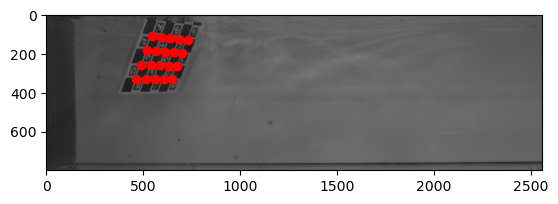

In [60]:
i = 100
fr = rows[i]['framenum']

cap.set(1, fr)
ret, frame = cap.read()

fig, ax = plt.subplots()
ax.imshow(frame)
ax.plot(rows[i]['corners'][:,0,0], rows[i]['corners'][:,0,1], 'ro')

Don't forget to run the code block below to close the video file.

In [61]:
cap.release()

## Calibrate based on all the videos

This will run through all of the videos and detect the corners, then do the calibration and save it out as a `.toml` file

In [62]:
vidnames = [[os.path.join(videopath, fn)] for fn in videonames]
camnames = ['camA', 'camC']
ncams = len(vidnames)

camgroup = aniposelib.cameras.CameraGroup.from_names(camnames)

Run the `aniposelib` functions to calibrate based on the videos, and save out the calibration.

In [ ]:
camgroup.calibrate_videos(vidnames, board)
camgroup.dump('calibration.toml')

/Users/aclark11/Desktop/DecelCalibVideos/BG82/BG82_2L_calib-camA.mp4


100%|█████████████████████████████| 1618/1618 [04:09<00:00,  6.49it/s]


1618 boards detected
/Users/aclark11/Desktop/DecelCalibVideos/BG82/BG82_2L_calib-camC.mp4


100%|█████████████████████████████| 1618/1618 [04:19<00:00,  6.23it/s]


1618 boards detected
[{'name': 'camA', 'size': [2560, 800], 'matrix': [[3802.897078267988, 0.0, 1279.5], [0.0, 3802.897078267988, 399.5], [0.0, 0.0, 1.0]], 'distortions': [0.0, 0.0, 0.0, 0.0, 0.0], 'rotation': [0.0, 0.0, 0.0], 'translation': [0.0, 0.0, 0.0]}, {'name': 'camC', 'size': [2304, 800], 'matrix': [[8040.663032038012, 0.0, 1151.5], [0.0, 8040.663032038012, 399.5], [0.0, 0.0, 1.0]], 'distortions': [0.0, 0.0, 0.0, 0.0, 0.0], 'rotation': [0.0, 0.0, 0.0], 'translation': [0.0, 0.0, 0.0]}]
defaultdict(<class 'int'>, {('camA', 'camC'): 1577, ('camC', 'camA'): 1577})
error:  49.71295031608234
n_samples: 200
{(0, 1): (1000, array([17.37204542, 75.49255349]))}
error: 49.36, mu: 17.4, ratio: 0.150
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.9536e+04                                    4.18e+05    
       1              3         1.1148e+04      8.39e+03       7.67e+02       2.23e+06    
       2              

# Load in the Sleap data files

In [64]:
from sleap.io.dataset import Labels

Load the calibration we did above. Make sure the file name is correct!

In [ ]:
camgroup = aniposelib.cameras.CameraGroup.load('calibration.toml')

Fill in the names of your cameras and the names of the Sleap `.slp` data files. You should have the same number of Sleap files as you do cameras. But if you trained the same network for multiple views, just repeat the name of the `.slp` file.

Note that the videos need to have matching names across the cameras. So you should have something like:
* test1_camA.mp4, test1_camB.mp4, test1_camC.mp4

or

* camA_test1.mp4, camB_test1.mp4, camC_test1.mp4

or something like that.

In [ ]:
camnames = ["camA", "camB", "camC"]

sleapfiles = ["SleapFilePathCamA",
            "SleapFilePathCamB",
            "SleapFilePathCamC"]

Load in the Sleap data files

In [70]:
labels = [Labels.load_file(fn) for fn in sleapfiles]

node_count = len(labels[0].skeletons[0].nodes)
node_names = [node.name for node in labels[0].skeletons[0].nodes]

videos = [[v1.backend.filename for v1 in l1.videos if re.search(c1, v1.backend.filename) is not None] for l1, c1 in zip(labels, camnames)]

Function to separate the name of a video and the camera names, so that we can match up videos for different cameras.

In [71]:
def separate_video_and_camera(vidname, camnames):
    fn1 = re.sub(r'\\', '/', vidname)
    fn1 = os.path.basename(fn1)

    for cam1 in camnames:
        fn1, nsub = re.subn(cam1, 'CAMERA', fn1)
        if nsub == 1:
            matched_camera = cam1
            break
    else:
        matched_camera = None

    return fn1, matched_camera

Pull out the $x$ and $y$ coordinates from the Sleap data files and match the same point in the same frame across cameras.

In [72]:
nodenames = [n.name for n in labels[0].skeletons[0].nodes]

ptsall = []
for l1, cam1 in zip(labels, camnames):
    pts = []
    for v1 in l1.videos:
        vidname1, camname1 = separate_video_and_camera(v1.backend.filename, camnames)
        if camname1 != cam1:
            continue
        
        frames = l1.get(v1)
        frame_idx = [lf.frame_idx for lf in frames]

        col_ind = pd.MultiIndex.from_product([[camname1], ['x', 'y']],
                                             names = ['camera', 'point'])
        row_ind = pd.MultiIndex.from_product([[vidname1], frame_idx, nodenames], 
                                             names = ['video', 'frame', 'node'])

        pts1 = pd.DataFrame(index = row_ind, columns=col_ind)

        for lf in frames:
            if len(lf.user_instances) == 1:
                inst = lf.user_instances[0]
            elif len(lf.predicted_instances) == 1: #flip with above if to test predictions over clicked points
                inst = lf.predicted_instances[0]
            else:
                print("Error!")
                assert(False)
            
            pts1.loc[(vidname1, lf.frame_idx, slice(None)), (camname1, slice(None))] = inst.numpy()

        pts.append(pts1)
    
    ptsall.append(pd.concat(pts, axis=0))

ptsall = pd.concat(ptsall, axis=1)

In [73]:
ptsall.head()

camera                                                    camA              \
point                                                        x           y   
video                           frame node                                   
BG82_2L_Tr9_Br2_1BLS-CAMERA.mp4 304   Snout         920.877089  624.066151   
                                      MidPelvFins  1009.307259  635.478737   
                                      AnalBase     1061.075852  622.296322   
                                      PeduncleBot  1128.402893  576.517669   
                                      LeftPecBase   995.969751  618.706277   

camera                                                   camC              
point                                                       x           y  
video                           frame node                                 
BG82_2L_Tr9_Br2_1BLS-CAMERA.mp4 304   Snout        759.423523  639.980835  
                                      MidPelvFins  832.929199  656.830017  
                                      AnalBase     896.458496   640.31189  
                                      PeduncleBot   944.29364  584.561279  
                                      LeftPecBase  807.206299  633.163025

Reshape the DataFrame into a 3D numpy matrix. Should have shape $C \times N \times 2$, where $C$ is the number of cameras, $N$ is the number of points, and 2 is for $x$ and $y$ coordinates.

In [74]:
ptsmatrix = ptsall.to_numpy().reshape((-1, 2, 2))
ptsmatrix = ptsmatrix.transpose((1,0,2)).astype(np.float64)
ptsmatrix.shape

(2, 421050, 2)

Show the first point in each camera so that we can compare to the DataFrame above. Should have x and y in the columns and cameras in the rows.

In [75]:
ptsmatrix[:,0,:]

array([[920.87708881, 624.06615073],
       [759.42352295, 639.98083496]])

Triangulate the points to 3D. NB - it's important to do the undistortion. Without it, we get *terrible* reprojection errors.

In [76]:
pts3d = camgroup.triangulate(ptsmatrix, progress=True, undistort=True)

100%|███████████████████████| 421050/421050 [01:21<00:00, 5179.20it/s]


...and compute the reprojection error.

In [77]:
reproj_err = camgroup.reprojection_error(pts3d, ptsmatrix, mean=False)
errors_norm = np.linalg.norm(reproj_err, axis=2)

In [78]:
errors_norm[:,0:5]

array([[1.41510918, 1.15352032, 0.32256756, 0.30155017, 0.87770228],
       [1.75737563, 1.45430376, 0.41207917, 0.38779332, 1.09893147]])

Now build up the same DataFrame as the original points so that we can merge them all.

First for the 3D points themselves

In [79]:
col_ind = pd.MultiIndex.from_product([['3D'], ['x', 'y', 'z']],
                                        names = ['camera', 'point'])

pts3d = pd.DataFrame(pts3d, index=ptsall.index, columns=col_ind)

...and then for the reprojection error. The original reprojection error gives us errors in both $x$ and $y$, but we're just interested in the distance, so we use `np.linalg.norm` to get the distance and then merge it into a DataFrame

In [80]:
col_ind = pd.MultiIndex.from_product([camnames, ['reproj_err']],
                                        names = ['camera', 'point'])

errors_norm = pd.DataFrame(errors_norm.T, index=ptsall.index, columns=col_ind)

These are the median reprojection errors. Make sure they're not too big.

In [81]:
errors_norm.groupby(level=2).median()

camera,camA,camC
point,reproj_err,reproj_err
node,,
AnalBase,2.254886,2.885342
AnalFinBase,1.476101,1.896030
AnalFinBot,3.280268,4.240011
AnalFinBot2,3.144148,4.082881
AnalFinTop,1.592888,2.054047
CaudalBot,3.222558,4.248210
CaudalBot2,2.365937,3.095330
CaudalMid,2.285956,3.025133


Then we merge all of the data frames so that we have the 2D x and y coordinates and the 3D coordinates with reprojection errors.

In [82]:
ptsall3d = pd.concat((ptsall, errors_norm, pts3d), axis=1)
ptsall3d.head()

camera                                                    camA              \
point                                                        x           y   
video                           frame node                                   
BG82_2L_Tr9_Br2_1BLS-CAMERA.mp4 304   Snout         920.877089  624.066151   
                                      MidPelvFins  1009.307259  635.478737   
                                      AnalBase     1061.075852  622.296322   
                                      PeduncleBot  1128.402893  576.517669   
                                      LeftPecBase   995.969751  618.706277   

camera                                                   camC              \
point                                                       x           y   
video                           frame node                                  
BG82_2L_Tr9_Br2_1BLS-CAMERA.mp4 304   Snout        759.423523  639.980835   
                                      MidPelvFins  832.929199  656.830017   
                                      AnalBase     896.458496   640.31189   
                                      PeduncleBot   944.29364  584.561279   
                                      LeftPecBase  807.206299  633.163025   

camera                                                  camA       camC  \
point                                             reproj_err reproj_err   
video                           frame node                                
BG82_2L_Tr9_Br2_1BLS-CAMERA.mp4 304   Snout         1.415109   1.757376   
                                      MidPelvFins   1.153520   1.454304   
                                      AnalBase      0.322568   0.412079   
                                      PeduncleBot   0.301550   0.387793   
                                      LeftPecBase   0.877702   1.098931   

camera                                                     3D             \
point                                                       x          y   
video                           frame node                                 
BG82_2L_Tr9_Br2_1BLS-CAMERA.mp4 304   Snout       -137.915491  49.354722   
                                      MidPelvFins -108.032827  61.275234   
                                      AnalBase     -89.097334  60.769734   
                                      PeduncleBot  -61.441213  51.357920   
                                      LeftPecBase -110.676135  54.341722   

camera                                                          
point                                                        z  
video                           frame node                      
BG82_2L_Tr9_Br2_1BLS-CAMERA.mp4 304   Snout        1104.321264  
                                      MidPelvFins  1101.385757  
                                      AnalBase     1107.542000  
                                      PeduncleBot  1098.323073  
                                      LeftPecBase  1094.490964

And then rearrange the MultiIndexes so that we can save it in a simple CSV format easily.

In [83]:
ptsall3d.columns = ['_'.join(reversed(c)) for c in ptsall3d.columns.to_flat_index()]
ptsall3d.reset_index(inplace=True)
ptsall3d.head()

,video,frame,node,x_camA,y_camA,x_camC,y_camC,reproj_err_camA,reproj_err_camC,x_3D,y_3D,z_3D
0,BG82_2L_Tr9_Br2_1BLS-CAMERA.mp4,304,Snout,920.877089,624.066151,759.423523,639.980835,1.415109,1.757376,-137.915491,49.354722,1104.321264
1,BG82_2L_Tr9_Br2_1BLS-CAMERA.mp4,304,MidPelvFins,1009.307259,635.478737,832.929199,656.830017,1.153520,1.454304,-108.032827,61.275234,1101.385757
2,BG82_2L_Tr9_Br2_1BLS-CAMERA.mp4,304,AnalBase,1061.075852,622.296322,896.458496,640.31189,0.322568,0.412079,-89.097334,60.769734,1107.542000
3,BG82_2L_Tr9_Br2_1BLS-CAMERA.mp4,304,PeduncleBot,1128.402893,576.517669,944.29364,584.561279,0.301550,0.387793,-61.441213,51.357920,1098.323073
4,BG82_2L_Tr9_Br2_1BLS-CAMERA.mp4,304,LeftPecBase,995.969751,618.706277,807.206299,633.163025,0.877702,1.098931,-110.676135,54.341722,1094.490964


And save! Remember to adjust the file name as needed.

In [ ]:
ptsall3d.to_csv('triangulatedpoints.csv', index=False)